# Melanoma Detection with Convolutional Neural Network

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


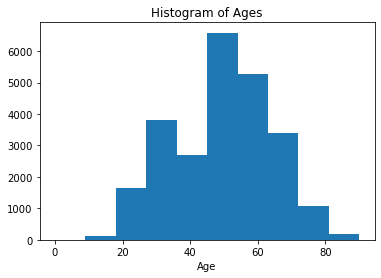

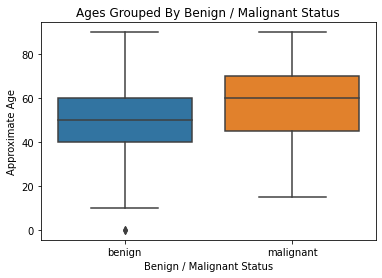

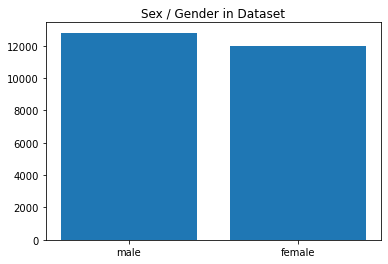

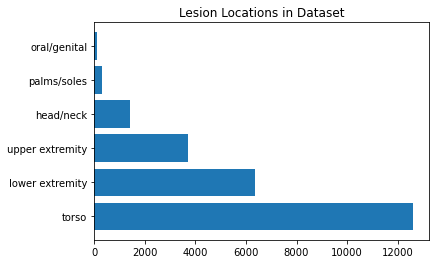

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



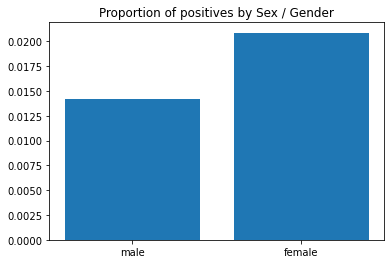



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



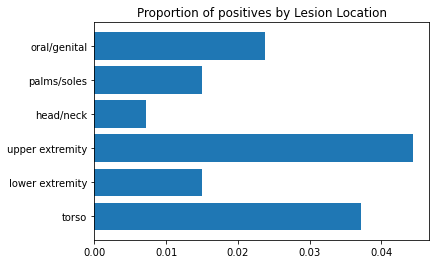

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## CNN Mark \#1

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 2


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# helper function for padding images one at a time
def pad2d_4k6k(_image):

    rows = _image.shape[1]
    cols = _image.shape[2]

    top = np.ceil((4000 - rows)/2).astype('int')
    bottom = np.floor((4000 - rows)/2).astype('int')
    right = np.ceil((6000 - cols)/2).astype('int')
    left = np.floor((6000 - cols)/2).astype('int')

    pad_func = nn.ConstantPad2d((left, right, top, bottom), 0)
    
    return pad_func(_image)


# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
    
        pad_image = pad2d_4k6k(_image)
        
        image_list.append(torch.unsqueeze(pad_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 2

transf = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "train.csv"), 
                            num_samples=2*24408, up_sample=True, start_ind=0, transform=transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "val.csv"), 
                            num_samples=100, up_sample=True, start_ind=0, transform=transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [8]:
# functions to show the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

In [9]:
class Net(nn.Module):
    def __init__(self):
        '''
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        '''
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 15, 5)
        self.conv3 = nn.Conv2d(15, 25, 5)
        self.conv4 = nn.Conv2d(25, 40, 5)
        self.conv5 = nn.Conv2d(40, 50, 5)
        self.conv6 = nn.Conv2d(50, 60, 5)
        self.conv7 = nn.Conv2d(60, 75, 5)
        self.conv8 = nn.Conv2d(75, 85, 5)
        self.conv9 = nn.Conv2d(85, 100, 5)
        self.fc1 = nn.Linear(100*7*3, 100) 
        self.fc2 = nn.Linear(100, 85)
        self.fc3 = nn.Linear(85, 1)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = self.pool(F.relu(self.conv8(x)))
        x = self.pool(F.relu(self.conv9(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


In [10]:
load_weights = False
create_new_weights = False
PATH = './melanoma_cnn.pth'

if load_weights:
    print('Loading the pre-trained CNN weights.')
    
    # network weights load
    net = Net()
    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=24408, gamma=0.1)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    mini_batch = 0
    net = Net().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=24408, gamma=0.1)
    
    

In [11]:
learn_weights = False

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 24408

        # print every 25 mini-batch
        if i % 25 == 0:
            print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
            print(f'[Epoch {epoch}, Batch {mini_batch % 24408}] Loss: {running_loss / (i+1)}\n')

        # save every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)

        # validate every 1000 mini-batch
        if i % 1000 == 0:

            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))

            precision, recall, thresholds = metrics.precision_recall_curve(ground_truths, probs)
            f1scores = 2 * (precision * recall) / (precision + recall)
            opt_thresh = thresholds[np.argmax(f1scores)]
            opt_preds = probs > opt_thresh


            print("Using max F1-Score threshold, the confusion matrix is:\n", metrics.confusion_matrix(ground_truths, opt_preds))
            
            
            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 3000 == 0:
            uPATH = f'./melanoma_cnn_{epoch}e_{mini_batch % 24408}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 0


# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [12]:
batch_size = 2

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data", "jpgs"), 
                            patientfile=os.path.join("train_data", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign


In [13]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [14]:
os.listdir('./saved_weights/')

['melanoma_cnn_4e_13368b.pth',
 'melanoma_cnn_5e_115b.pth',
 'melanoma_cnn_1e_18456b.pth',
 'melanoma_cnn_3e_13776b.pth',
 'melanoma_cnn_3e_1776b.pth',
 'melanoma_cnn_0e_24103b.pth',
 'melanoma_cnn_2e_11184b.pth',
 'melanoma_cnn_4e_1368b.pth']

Loading: melanoma_cnn_0e_24103b.pth

	 Processing Image #1 ... Running Time 2.4432945251464844
	 Current Testing Loss: 0.7828360199928284

	 Processing Image #201 ... Running Time 57.27424120903015
	 Current Testing Loss: 0.5500073955200686

	 Processing Image #401 ... Running Time 112.32266116142273
	 Current Testing Loss: 0.5496193143488163

	 Processing Image #601 ... Running Time 173.55842185020447
	 Current Testing Loss: 0.5411016299974086

	 Processing Image #801 ... Running Time 235.28636932373047
	 Current Testing Loss: 0.5492152393495947

	 Processing Image #1001 ... Running Time 296.33389711380005
	 Current Testing Loss: 0.5460158429608611

	 Processing Image #1201 ... Running Time 358.06497073173523
	 Current Testing Loss: 0.5428347607916485

	 Processing Image #1401 ... Running Time 416.26105880737305
	 Current Testing Loss: 0.5440495269912455

	 Processing Image #1601 ... Running Time 481.8021879196167
	 Current Testing Loss: 0.5414896843752611

	 Processing Image #1801 ..

	 Processing Image #7201 ... Running Time 1999.236485004425
	 Current Testing Loss: 0.5491773362140363

	 Processing Image #7401 ... Running Time 2055.1518239974976
	 Current Testing Loss: 0.549735698397016

	 Processing Image #7601 ... Running Time 2109.3897881507874
	 Current Testing Loss: 0.5497280928450599

	 Processing Image #7801 ... Running Time 2163.7114160060883
	 Current Testing Loss: 0.5497404117642366

	 Processing Image #8001 ... Running Time 2220.0181419849396
	 Current Testing Loss: 0.5492642238313438

	 Processing Image #8201 ... Running Time 2274.9054577350616
	 Current Testing Loss: 0.5487841448849496

******* Final Testing Loss: 0.5489027989550119 *******

Loading: melanoma_cnn_2e_11184b.pth

	 Processing Image #1 ... Running Time 1.1358778476715088
	 Current Testing Loss: 0.7266090512275696

	 Processing Image #201 ... Running Time 57.68668746948242
	 Current Testing Loss: 0.5294431038200855

	 Processing Image #401 ... Running Time 112.47530889511108
	 Current Test

	 Processing Image #5801 ... Running Time 1616.9274125099182
	 Current Testing Loss: 0.5298408394055335

	 Processing Image #6001 ... Running Time 1673.077576637268
	 Current Testing Loss: 0.5298966352962223

	 Processing Image #6201 ... Running Time 1725.9878010749817
	 Current Testing Loss: 0.5322567886077961

	 Processing Image #6401 ... Running Time 1781.46533036232
	 Current Testing Loss: 0.5317556542742699

	 Processing Image #6601 ... Running Time 1835.7380993366241
	 Current Testing Loss: 0.5318714137491255

	 Processing Image #6801 ... Running Time 1891.7674193382263
	 Current Testing Loss: 0.5316423382393751

	 Processing Image #7001 ... Running Time 1949.9936497211456
	 Current Testing Loss: 0.5304017823481583

	 Processing Image #7201 ... Running Time 2003.5982263088226
	 Current Testing Loss: 0.5309021668131051

	 Processing Image #7401 ... Running Time 2059.9313633441925
	 Current Testing Loss: 0.5317372941051933

	 Processing Image #7601 ... Running Time 2114.79101824760

	 Processing Image #4401 ... Running Time 1238.9360904693604
	 Current Testing Loss: 0.5304902355715139

	 Processing Image #4601 ... Running Time 1294.8796067237854
	 Current Testing Loss: 0.5309600841451513

	 Processing Image #4801 ... Running Time 1346.2458953857422
	 Current Testing Loss: 0.5321138636967394

	 Processing Image #5001 ... Running Time 1402.6557009220123
	 Current Testing Loss: 0.5300272377047752

	 Processing Image #5201 ... Running Time 1461.5572936534882
	 Current Testing Loss: 0.5288192382771973

	 Processing Image #5401 ... Running Time 1515.8015389442444
	 Current Testing Loss: 0.5291899714042405

	 Processing Image #5601 ... Running Time 1573.183268070221
	 Current Testing Loss: 0.5299893467135459

	 Processing Image #5801 ... Running Time 1628.0961201190948
	 Current Testing Loss: 0.529256481211793

	 Processing Image #6001 ... Running Time 1685.3487703800201
	 Current Testing Loss: 0.529329827839868

	 Processing Image #6201 ... Running Time 1738.23917627334

	 Processing Image #3001 ... Running Time 834.520632982254
	 Current Testing Loss: 0.5356723294903007

	 Processing Image #3201 ... Running Time 887.4121544361115
	 Current Testing Loss: 0.5381619294664399

	 Processing Image #3401 ... Running Time 944.4760072231293
	 Current Testing Loss: 0.5349482451064588

	 Processing Image #3601 ... Running Time 999.3789813518524
	 Current Testing Loss: 0.5356238467664329

	 Processing Image #3801 ... Running Time 1056.4772441387177
	 Current Testing Loss: 0.5334834690587394

	 Processing Image #4001 ... Running Time 1111.395004749298
	 Current Testing Loss: 0.533982656608014

	 Processing Image #4201 ... Running Time 1170.9792821407318
	 Current Testing Loss: 0.5311326432351674

	 Processing Image #4401 ... Running Time 1228.0218920707703
	 Current Testing Loss: 0.5306409760088453

	 Processing Image #4601 ... Running Time 1283.033370256424
	 Current Testing Loss: 0.531111829606545

	 Processing Image #4801 ... Running Time 1334.478985786438
	 Cu

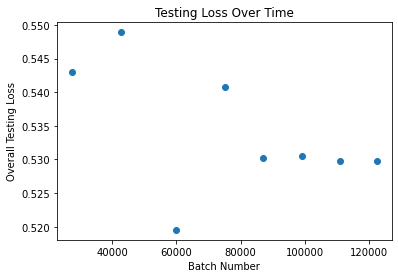

In [15]:
weight_fnames = os.listdir('./saved_weights/')
weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights/{fname}', map_location=device)
    
    # network weights load
    net = Net().to(device)
    net.load_state_dict(checkpoint['model_state_dict'])    
    criterion = nn.BCELoss()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 100 == 0:
                print(f"\t Processing Image #{2*i + 1} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')
                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')
    
    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))         
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results/results_cnn_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

In [ ]:
best_batch_size = 7777

with open(f'./saved_results/results_cnn_{best_batch_size}.pkl', 'wb') as f:
    res = pickle.load(f)
    
    
ground_truths = res["ground_truths"]
probs = res["probs"]

## Testing Results

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.show()

print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))

accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))


plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()

precision, recall, thresholds = metrics.precision_recall_curve(ground_truths, probs)
f1scores = 2 * (precision * recall) / (precision + recall)
gmeans = np.sqrt(precision * recall)
f1_opt_thresh = thresholds[np.argmax(f1scores)]
f1_opt_preds = probs > f1_opt_thresh
gm_opt_thresh = thresholds[np.argmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh


print("Using max F1-Score threshold, the confusion matrix is:\n", metrics.confusion_matrix(ground_truths, f1_opt_preds))
print("Using max G-Mean threshold, the confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds))